In [1]:
using LinearAlgebra # need this to do the cross product
using PyPlot # Using Plots http://docs.juliaplots.org/latest/install/
# https://gist.github.com/gizmaa/7214002 - examples uing PyPlot in Julia

In [2]:
e = 1.602176634e-19
#m_e = 9.1093837015e-31
m_Ag = 107.9*1.66e-27
gyro =  e/(2.0*m_Ag)
mu_e=1.85480201566e-23;
mu_B = 9.27400968e-24;

First set up a SG experiment with field in z direction and fire beam along x direction

In [3]:
machine_dim_x = 0.1
machine_dim_y = 0.035 + 0.01
machine_dim_z = 0.1

B0 = 1.4
gradB0 = 1800;

In [108]:
function B(r)
    B = zeros(3)
    B[1] = -gradB0*r[1]
#     B[3] = B0 + gradB0*r[3]
    B[3] = B0.*(0.5.*tanh.(800.0.*r[3].+2.0).+0.5);
    return B
end;

In [109]:
# https://en.wikipedia.org/wiki/Gradient#Gradient_of_a_vector
function gradB(r)
    gradB = zeros(3,3)
    gradB[3,3] = gradB0
    gradB[3,2] = B0.*0.5.*sech.(800.0.*r[3].+2.0).^2
    ## gradB[1,1] = -gradB0
    return gradB
end;

$\Delta t$ needs to be smaller than this:

In [6]:
2*pi/(gyro*B0)

1.0034620842205417e-5

In [7]:
v0 = 600.0
dt = 5.0e-7
t_max = machine_dim_y/v0
times = collect(0:dt:t_max)

mu = [1/sqrt(3),1/sqrt(3),1/sqrt(3)]*mu_e
r = [0,-0.01,0]
v = [0,v0,0]
r_save = zeros(length(times),3)
mu_save = zeros(length(times),3);

In [8]:
# evolution for mu inspired by https://www.particleincell.com/2011/vxb-rotation/
for (i,t) in enumerate(times)
    
    r_save[i,:] = r
    mu_save[i,:] = mu
    
    v += (0.5*dt*(mu'*gradB(r))/m_Ag)'
    Br = B(r)
    s = 2.0/(1+(norm(Br)*gyro*dt*0.5)^2)
    mu_prime = mu + 0.5*dt*gyro*cross(mu,Br)
    mu += 0.5*dt*gyro*s*cross(mu_prime,Br)
    r += dt*v
    v += (0.5*dt*(mu'*gradB(r))/m_Ag)'
    

end

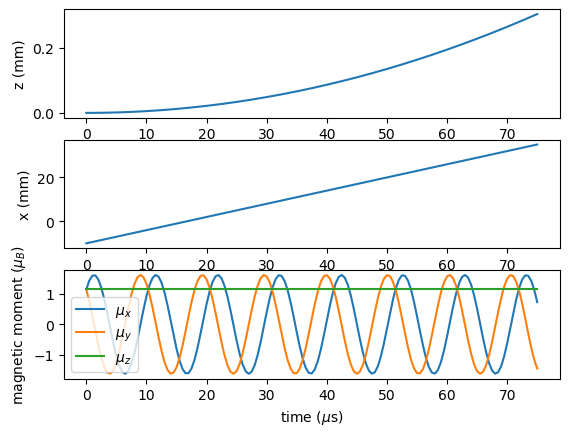

In [9]:
n = 1 # plot every n points in case the arrays become too large
times_plot = times[1:n:end]./1e-6
r_save_plot = r_save[1:n:end,:]./1e-3
mu_save_plot = mu_save[1:n:end,:]./mu_B;

subplot(311)
plot(times_plot,(r_save_plot[:,3]), label="z");
ylabel("z (mm)")

subplot(312)
plot(times_plot,(r_save_plot[:,2]), label="x");
ylabel("x (mm)")

subplot(313)
plot(times_plot,mu_save_plot[:,1], label=L"$\mu_x$")
plot(times_plot,mu_save_plot[:,2], label=L"$\mu_y$")
plot(times_plot,mu_save_plot[:,3], label=L"$\mu_z$")
xlabel(L"time ($\mu$s)")
ylabel(L"magnetic moment ($\mu_B$)")
legend();

Now let's initialise many different initial conditions and see what $z$ we end up with.

In [10]:
v0 = 600.0
dt = 5.0e-7
t_max = machine_dim_y/v0
times = collect(0:dt:t_max);

In [87]:
acos(0.4)

1.1592794807274085

In [117]:
np = 1000
zs = zeros(np)
ys = zeros(np)
mus = zeros(np)
muz_init = zeros(np)

for p in 1:np
    
    # https://mathworld.wolfram.com/SphericalCoordinates.html
    # https://math.stackexchange.com/a/1586583
    theta = acos(2*rand()-1)
    phi = rand()*2*pi
    mu = [mu_e*sin(theta)*cos(phi), mu_e*sin(phi)*sin(theta), mu_e*cos(theta)]
    r = [0,-0.01,0]
    v = [0,v0,0]
    muz_init[p] = mu[3]


    for (i,t) in enumerate(times)

        v += (0.5*dt*(mu'*gradB(r))/m_Ag)'
        Br = B(r)
        s = 2.0/(1+(norm(Br)*gyro*dt*0.5)^2)
        mu_prime = mu + 0.5*dt*gyro*cross(mu,Br)
        mu += 0.5*dt*gyro*s*cross(mu_prime,Br)
        r += dt*v
        v += (0.5*dt*(mu'*gradB(r))/m_Ag)'
    end
    
    zs[p] = r[3]
    ys[p] = r[2]
    mus[p] = mu[3]
end

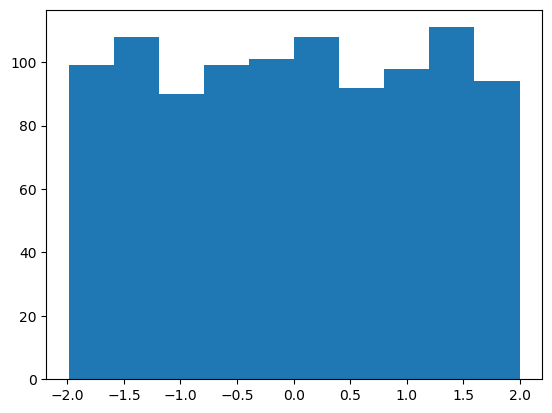

In [121]:
hist(muz_init./mu_B);

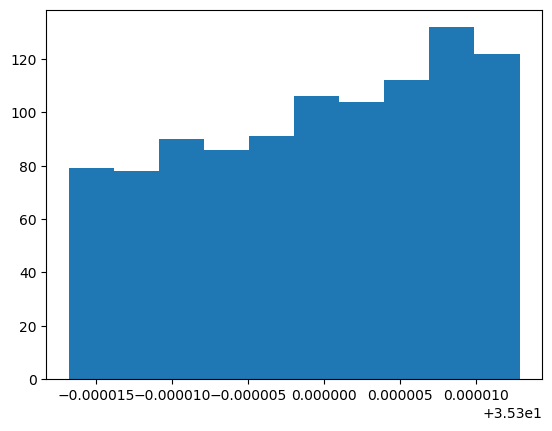

In [119]:
hist(ys./1e-3);

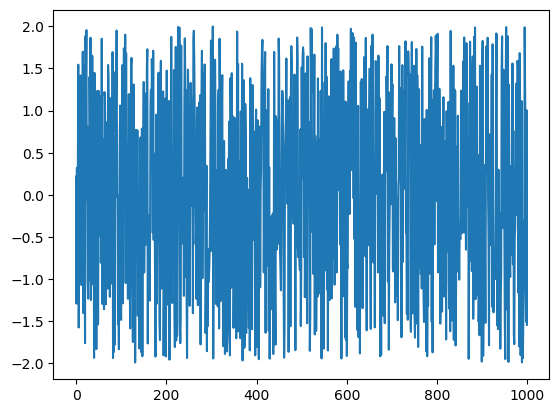

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14fe8d190>

In [120]:
plot(mus./mu_B)

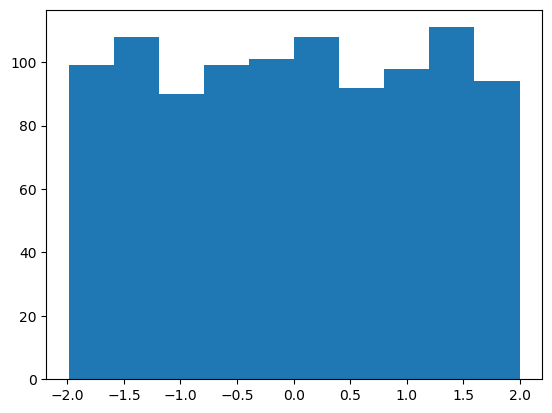

([99.0, 108.0, 90.0, 99.0, 101.0, 108.0, 92.0, 98.0, 111.0, 94.0], [-1.9884675496824138, -1.5898930022808728, -1.191318454879332, -0.7927439074777913, -0.39416936007625036, 0.004405187325290605, 0.40297973472683113, 0.8015542821283721, 1.200128829529913, 1.598703376931454, 1.9972779243329948], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x14f7a7f50>, PyObject <matplotlib.patches.Rectangle object at 0x14f7a7cd0>, PyObject <matplotlib.patches.Rectangle object at 0x14ff8fb50>, PyObject <matplotlib.patches.Rectangle object at 0x14f80d950>, PyObject <matplotlib.patches.Rectangle object at 0x14f80d750>, PyObject <matplotlib.patches.Rectangle object at 0x14f805290>, PyObject <matplotlib.patches.Rectangle object at 0x14f80de50>, PyObject <matplotlib.patches.Rectangle object at 0x14f805850>, PyObject <matplotlib.patches.Rectangle object at 0x14f80dcd0>, PyObject <matplotlib.patches.Rectangle object at 0x14f80dad0>])

In [122]:
hist(mus./mu_B)